# Notebook 2: Gradient Descent

## Learning Goal

The goal of this notebook is to gain intuition for various gradient descent methods by visualizing and applying these methods to some simple two-dimensional surfaces. Methods studied include ordinary gradient descent, gradient descent with momentum, NAG, ADAM, and RMSProp.


## Overview

In this notebook, we will visualize what different gradient descent methods are doing using some simple surfaces. From the onset, we emphasize that doing gradient descent on the surfaces is different from performing gradient descent on a loss function in Machine Learning (ML). The reason is that in ML not only do we want to find good minima, we want to find good minima that generalize well to new data. Despite this crucial difference, we can still build intuition about gradient descent methods by applying them to simple surfaces (see related blog posts [here](http://ruder.io/optimizing-gradient-descent/) and [here](http://tiao.io/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/)).

## Surfaces

We will consider three simple surfaces: a quadratic minimum of the form $$z=ax^2+by^2,$$ a saddle-point of the form $$z=ax^2-by^2,$$ and [Beale's Function](https://en.wikipedia.org/wiki/Test_functions_for_optimization), a convex function often used to test optimization problems of the form:
$$z(x,y) = (1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2$$

These surfaces can be plotted using the cells below. 


In [1]:
#This cell sets up basic plotting functions awe
#we will use to visualize the gradient descent routines.

#Make plots interactive
#%matplotlib notebook

#Make plots static
%matplotlib inline

#Make 3D plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib import animation
from IPython.display import HTML
from matplotlib.colors import LogNorm
#from itertools import zip_longest

#Import Numpy
import numpy as np

#Define function for plotting 

def plot_surface(x, y, z, azim=-60, elev=40, dist=10, cmap="RdYlBu_r"):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap,
             'linewidth': 20, 'antialiased': True,
             'vmin': -2, 'vmax': 2}
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist=dist
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-2, 2)
    
    plt.xticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    plt.yticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    ax.set_zticks([-2, -1, 0, 1, 2])
    ax.set_zticklabels(["-2", "-1", "0", "1", "2"])
    
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;

def overlay_trajectory_quiver(ax,obj_func,trajectory, color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.quiver(xs[:-1], ys[:-1], zs[:-1], xs[1:]-xs[:-1], ys[1:]-ys[:-1],zs[1:]-zs[:-1],color=color,arrow_length_ratio=0.3)
    
    return ax;

def overlay_trajectory(ax,obj_func,trajectory,label,color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.plot(xs,ys,zs, color, label=label)
    
    return ax;

    
def overlay_trajectory_contour_M(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    ax.plot(xs[-1],ys[-1],color+'>', markersize=14)
    return ax;

def overlay_trajectory_contour(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    return ax;

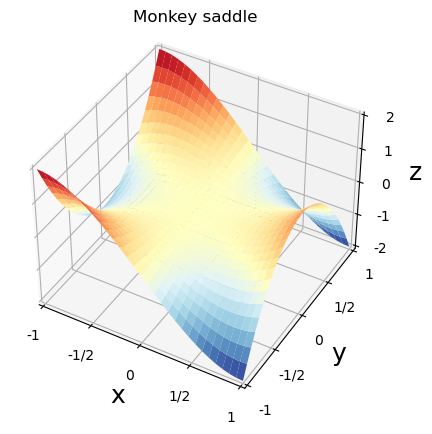

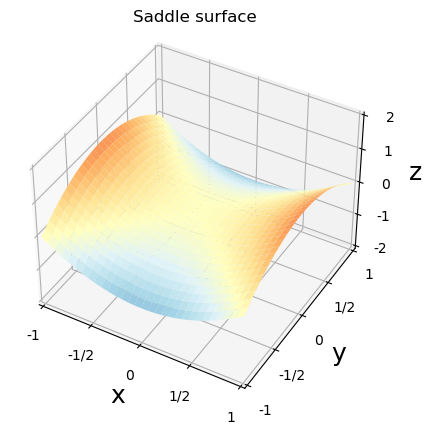

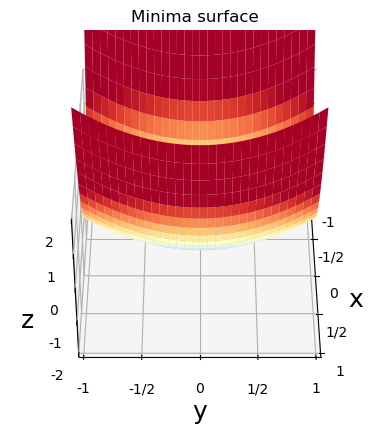

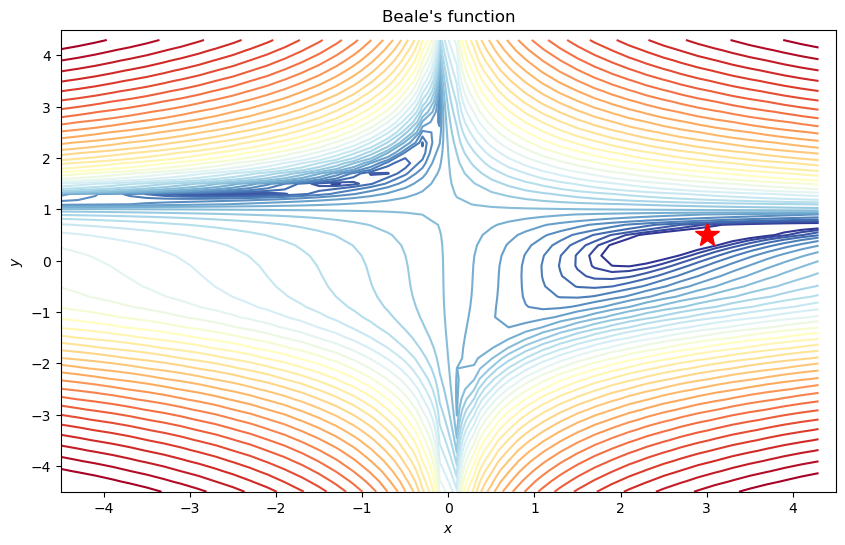

In [2]:
#DEFINE SURFACES WE WILL WORK WITH

#Define monkey saddle and gradient
def monkey_saddle(x,y):
    return x**3 - 3*x*y**2

def grad_monkey_saddle(params):
    x=params[0]
    y=params[1]
    grad_x= 3*x**2-3*y**2
    grad_y= -6*x*y
    return [grad_x,grad_y]

#Define saddle surface

def saddle_surface(x,y,a=1,b=1):
    return a*x**2-b*y**2

def grad_saddle_surface(params,a=1,b=1):
    x=params[0]
    y=params[1]
    grad_x= a*x
    grad_y= -1*b*y
    return [grad_x,grad_y]


# Define minima_surface

def minima_surface(x,y,a=1,b=1):
    return a*x**2+b*y**2-1

def grad_minima_surface(params,a=1,b=1):
    x=params[0]
    y=params[1]
    grad_x= 2*a*x
    grad_y= 2*b*y
    return [grad_x,grad_y]


def beales_function(x,y):
    return np.square(1.5-x+x*y)+np.square(2.25-x+x*y*y)+np.square(2.625-x+x*y**3)
    return f

def grad_beales_function(params):
    x=params[0]
    y=params[1]
    grad_x=2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625-x+x*y**3)*(-1+y**3)
    grad_y=2*(1.5-x+x*y)*x+4*(2.25-x+x*y**2)*x*y+6*(2.625-x+x*y**3)*x*y**2
    return [grad_x,grad_y]

def contour_beales_function():
    #plot beales function
    x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
    fig, ax = plt.subplots(figsize=(10, 6))
    z=beales_function(x,y)
    cax = ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
    ax.plot(3,0.5, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-4.5, 4.5))
    
    return fig,ax
    
#Make plots of surfaces
plt.close() # closes previous plots
x, y = np.mgrid[-1:1:31j, -1:1:31j]
# Monkey saddle x**3 - 3*x*y**2
fig1,ax1=plot_surface(x,y,monkey_saddle(x,y))
ax1.set_title('Monkey saddle')
# Saddle x**2-y**2 
fig2,ax2=plot_surface(x,y,saddle_surface(x,y))
ax2.set_title('Saddle surface')
# Saddle x**2+y**2-1
fig3,ax3=plot_surface(x,y,minima_surface(x,y,5),0)
ax3.set_title('Minima surface')
#Contour plot of Beale's Function

fig4,ax4 =contour_beales_function()
ax4.set_title('Beale\'s function')
plt.show()


## Gradient descent with and without momentum

In this notebook, we will visualize various gradient descent algorithms used in machine learning. We will be especially interested in trying to understand how various hyperparameters -- especially the learning rate -- affect our performance. Here, we confine ourselves primarily to looking at the performance in the absence of noise. However, we encourage the reader to **experiment with playing with the noise strength below and seeing what differences introducing stochasticity makes**. 

Throughout, we denote the parameters by $\theta$ and the energy function we are trying to minimize by $E(\theta)$.

<b>Gradient Descent</b>

We start by considering a simple gradient descent method. In this method,
we will take steps in the direction of the local gradient. Given some parameters $\theta$, we adjust the parameters at each iteration so that

$$\theta_{t+1}= \theta_t - \eta_t \nabla_\theta E(\theta),$$

where we have introduced the learning rate $\eta_t$ that controls how large a step we take. In general, the algorithm is extremely sensitive to the choice of $\eta_t$. If $\eta_t$ is too large, then one can wildly oscillate around minima and miss important structure at small scales. This problem is amplified if our gradient computations are noisy and inexact (as is often the case in machine learning applications). If $\eta_t$ is too small, then the learning/minimization procedure becomes extremely slow. This raises the natural question: <i> What sets the natural scale for the learning rate and how can we adaptively choose it?</i> We discuss this extensively in Section IV of the review.

<b>Gradient Descent with Momentum</b>

One problem **with gradient descent is that it has no memory of where the "ball rolling down the hill" comes from**. This can be an issue when there are many shallow minima in our landscape. If we make an analogy with a ball rolling down a hill, the lack of memory is equivalent to having no inertia or momentum (i.e. completely overdamped dynamics). Without momentum, the ball has no kinetic energy and cannot climb out of shallow minima. 

Momentum becomes especially important when we start thinking about stochastic gradient descent with noisy, stochastic estimates of the gradient. In this case, we should remember where we were coming from and not react drastically to each new update.



Inspired by this, **we can add a memory or momentum term to the stochastic gradient descent term** above:

$$
v_{t}=\gamma v_{t-1}+\eta_{t}\nabla_\theta E(\theta_t),\\
\theta_{t+1}= \theta_t -v_{t},
$$

with $0\le \gamma < 1$ called the momentum parameter. When $\gamma=0$, this reduces to ordinary gradient descent, and increasing $\gamma$ increases the inertial contribution to the gradient. From the equations above, we can see that typical memory lifetimes of the gradient is given by $(1-\gamma)^{-1}$. For $\gamma=0$ as in gradient descent, the lifetime is just one step. For $\gamma=0.9$, we typically remember a gradient for ten steps. We will call this gradient descent with classical momentum or CM for short.

For large velocities, i.e. steep descents, the inertia term becomes large, effectively reducing the gradient term ($\eta_{t}\nabla_\theta E(\theta_t)$) and thus reducing the difference between $\theta_{t+1}$ and $\theta_t$, i.e. the step size. In this way we can traverse faster flat regions (small velocities) and traverse slower rugged regions, paying more attention to the details of the landscape.

A final widely used variant of gradient descent with momentum is called the Nesterov accelerated gradient (NAG). In NAG, rather than calculating the gradient at the current position, one calculates the gradient at the position momentum will carry us to at time $t+1$, namely, $\theta_t -\gamma v_{t-1}$. Thus, the update becomes
$$
v_{t}=\gamma v_{t-1}+\eta_{t}\nabla_\theta E(\theta_t-\gamma v_{t-1})\\
\theta_{t+1}= \theta_t -v_{t}
$$

Looks ahead by computing the gradient at the approximate future position of the parameters ($\theta_t-\gamma v_{t-1}$). This provides a more accurate adjustment by factoring in where the momentum is already taking you. This often results in better convergence and can avoid overshooting minima.

In [3]:
#This writes a simple gradient descent, gradient descent+ momentum,
#nesterov. 

#Mean-gradient based methods
def gd(grad, init, n_epochs=1000, eta=10**-4, noise_strength=0, **kwargs):
    #This is a simple optimizer
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        # computes \eta_{t}\nabla_\theta E(\theta_t)
        v=eta*(np.array(grad(params, **kwargs))+noise)
        # \theta_{t+1}= \theta_t - \eta_t \nabla_\theta E(\theta)
        params=params-v
        param_traj[j+1,]=params
    return param_traj


def gd_with_mom(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0, **kwargs):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params, **kwargs))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

def NAG(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0, **kwargs):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov, **kwargs))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

## Experiments with GD, CM, and NAG

Before introducing more complicated situations, let us experiment with these methods to gain some intuition.

Let us look at the dependence of GD on learning rate in a simple quadratic minima of the form $z=ax^2+by^2-1$ (Minima surface). Make  plots below for $\eta=0.1,0.5,1,1.01$ and $a=1$ and $b=1$. (to do this, you would have to add additional arguments to the function `gd` above in order to pass the new values of `a` and `b`; otherwise the default values `a=1` and `b=1` will be used by the gradient)
<ul>
<li>
What are the qualitatively different behaviors that arise as $\eta$ is increased?
<li> What does this tell us about the importance of choosing learning parameters? How do these change if we change $a$ and $b$ above? In particular how does anisotropy change the learning behavior?
<li> Make similar plots for CM and NAG? How do the learning rates for these procedures compare with those for GD?
</ul>


[[-2.00000000e+00  4.00000000e+00]
 [-1.60000000e+00  3.20000000e+00]
 [-1.28000000e+00  2.56000000e+00]
 [-1.02400000e+00  2.04800000e+00]
 [-8.19200000e-01  1.63840000e+00]
 [-6.55360000e-01  1.31072000e+00]
 [-5.24288000e-01  1.04857600e+00]
 [-4.19430400e-01  8.38860800e-01]
 [-3.35544320e-01  6.71088640e-01]
 [-2.68435456e-01  5.36870912e-01]
 [-2.14748365e-01  4.29496730e-01]
 [-1.71798692e-01  3.43597384e-01]
 [-1.37438953e-01  2.74877907e-01]
 [-1.09951163e-01  2.19902326e-01]
 [-8.79609302e-02  1.75921860e-01]
 [-7.03687442e-02  1.40737488e-01]
 [-5.62949953e-02  1.12589991e-01]
 [-4.50359963e-02  9.00719925e-02]
 [-3.60287970e-02  7.20575940e-02]
 [-2.88230376e-02  5.76460752e-02]
 [-2.30584301e-02  4.61168602e-02]
 [-1.84467441e-02  3.68934881e-02]
 [-1.47573953e-02  2.95147905e-02]
 [-1.18059162e-02  2.36118324e-02]
 [-9.44473297e-03  1.88894659e-02]
 [-7.55578637e-03  1.51115727e-02]
 [-6.04462910e-03  1.20892582e-02]
 [-4.83570328e-03  9.67140656e-03]
 [-3.86856262e-03  7

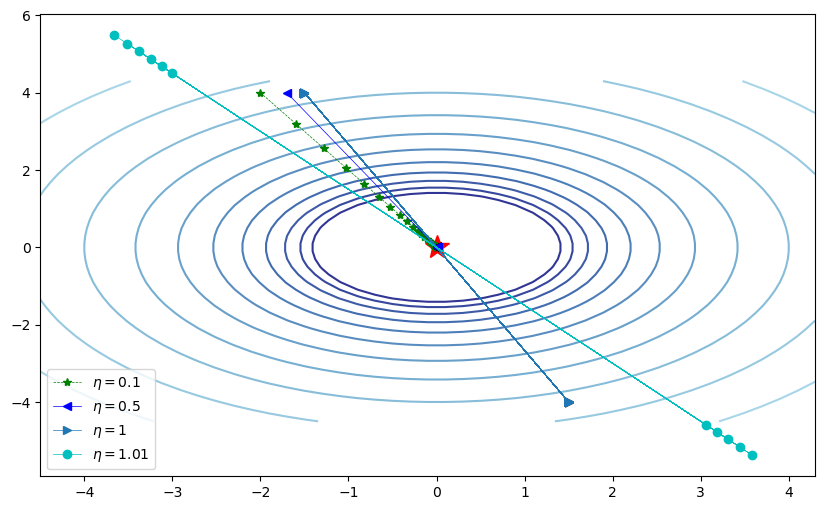

In [4]:
# Investigate effect of learning rate in GD
plt.close()
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(minima_surface(x,y,a,b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,4]
init2=[-1.7,4]
init3=[-1.5,4]
init4=[-3,4.5]
eta1=0.1
eta2=0.5
eta3=1
eta4=1.01
gd_1=gd(grad_minima_surface,init1, n_epochs=100, eta=eta1, a=a, b=b)
gd_2=gd(grad_minima_surface,init2, n_epochs=100, eta=eta2, a=a, b=b)
gd_3=gd(grad_minima_surface,init3, n_epochs=100, eta=eta3, a=a, b=b)
gd_4=gd(grad_minima_surface,init4, n_epochs=10, eta=eta4, a=a, b=b)
print(gd_1, gd_2, gd_3, gd_4)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=3)
plt.show()
#fig.savefig("GD3regimes.pdf", bbox_inches='tight')


For the function $x^{2}+y^{2}-1$, using a gradient descent algorithm, the learning rate $\eta = 0.1$ provides a smooth stable convergence, where the trajectory spirals towards the center with dimishing step; with $\eta = 0.5$ we have a faster convergence, the algorithm converges in just one step; for $\eta=1$ we are on the edge of divergence, the algorithm oscillates around the minimum between the initial point and its inverse double. For $\eta = 1.01$ the algorithm diverges, overshooting the minimum, and going further from the minimum at each step.

For $\eta = 0.5$ we have:
    params = np.array(init) 
    --> $\begin{equation}
            \begin{bmatrix}
                -1.7\\
                4
            \end{bmatrix}
            - 0.5 
            \begin{bmatrix}
                -2 \times 1.7\\
                2 \times 4
            \end{bmatrix} = 0
         \end{equation}$
         
Regardless of the initial condition the optimization converges in one step.

![gd_rev.jpg](./gd_rev.jpg)

For $a \not = b$ we obtain an anisotropic quadratic function. We can no longer have a single step convergence.

![anis_1.jpg](./anis_1.jpg)
![anis_2.jpg](./anis_2.jpg)

[[-2.00000000e+00  4.00000000e+00]
 [-1.60000000e+00  3.20000000e+00]
 [-1.08000000e+00  2.16000000e+00]
 [-6.04000000e-01  1.20800000e+00]
 [-2.45200000e-01  4.90400000e-01]
 [-1.67600000e-02  3.35200000e-02]
 [ 1.00812000e-01 -2.01624000e-01]
 [ 1.39435600e-01 -2.78871200e-01]
 [ 1.30860280e-01 -2.61720560e-01]
 [ 1.00400564e-01 -2.00801128e-01]
 [ 6.50905932e-02 -1.30181186e-01]
 [ 3.44174892e-02 -6.88349783e-02]
 [ 1.21974393e-02 -2.43948786e-02]
 [-1.35207348e-03  2.70414696e-03]
 [-7.85641518e-03  1.57128304e-02]
 [-9.53730299e-03  1.90746060e-02]
 [-8.47028630e-03  1.69405726e-02]
 [-6.24272069e-03  1.24854414e-02]
 [-3.88039375e-03  7.76078750e-03]
 [-1.92315153e-03  3.84630306e-03]
 [-5.59900114e-04  1.11980023e-03]
 [ 2.33705617e-04 -4.67411234e-04]
 [ 5.83767359e-04 -1.16753472e-03]
 [ 6.42044759e-04 -1.28408952e-03]
 [ 5.42774506e-04 -1.08554901e-03]
 [ 3.84584479e-04 -7.69168958e-04]
 [ 2.28572570e-04 -4.57145139e-04]
 [ 1.04852101e-04 -2.09704202e-04]
 [ 2.20214464e-05 -4

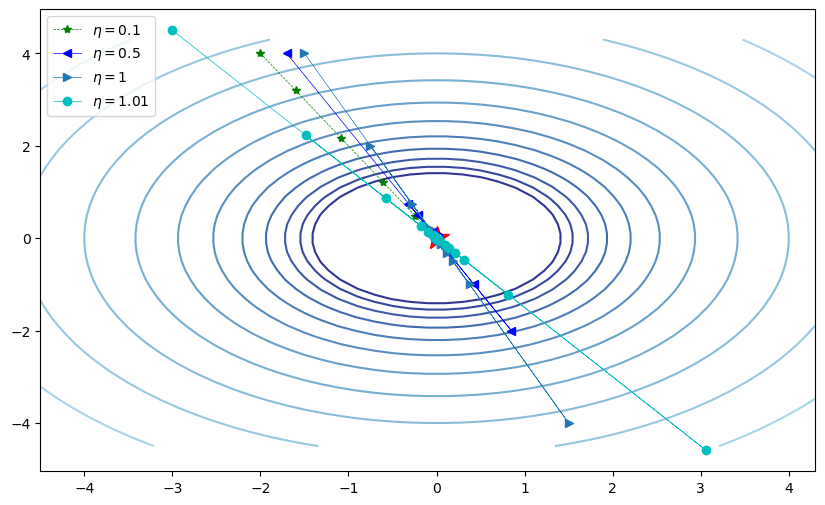

In [5]:
plt.close()
a,b = 1.0,1.0
gamma = 0.5
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(minima_surface(x,y,a,b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18) 

gd_mom_1=gd_with_mom(grad_minima_surface,init1, n_epochs=100, eta=eta1, a=a, b=b, gamma = gamma)
gd_mom_2=gd_with_mom(grad_minima_surface,init2, n_epochs=100, eta=eta2, a=a, b=b, gamma = gamma)
gd_mom_3=gd_with_mom(grad_minima_surface,init3, n_epochs=100, eta=eta3, a=a, b=b, gamma = gamma)
gd_mom_4=gd_with_mom(grad_minima_surface,init4, n_epochs=100, eta=eta4, a=a, b=b, gamma = gamma)
print(gd_mom_1, gd_mom_2, gd_mom_3, gd_mom_4)
overlay_trajectory_contour(ax,gd_mom_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_mom_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_mom_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_mom_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.show()

Using gd with momentum we can accelerate convergence at low $\eta$ (for the case $\eta=0.1$ the system reaches the $10^{-1}$ order of magnitude in 5 steps while it took 8 using the gd) and in this case the system oscillates back and forth before eventually spiraling into the minimum, while it went straight to the minimum without recoiling using gd.

For the case $\eta=0.5$ the algorithm oscillates around the minimum and it doesn't converge in oneshot like in the case of gd.

For the case $\eta= 1$ and $1.01$ the algorithm oscillates around the minimum and it doesn't overshoot it leading to results which are comparable to those obtained for $\eta=0.5$. We can note that the oscillations decrease as we approach the minimum as it would be expected given the interplay between momenta and gradients.

[[-2.00000000e+00  4.00000000e+00]
 [-1.60000000e+00  3.20000000e+00]
 [-1.12000000e+00  2.24000000e+00]
 [-7.04000000e-01  1.40800000e+00]
 [-3.96800000e-01  7.93600000e-01]
 [-1.94560000e-01  3.89120000e-01]
 [-7.47520000e-02  1.49504000e-01]
 [-1.18784000e-02  2.37568000e-02]
 [ 1.56467200e-02 -3.12934400e-02]
 [ 2.35274240e-02 -4.70548480e-02]
 [ 2.19742208e-02 -4.39484416e-02]
 [ 1.69580954e-02 -3.39161907e-02]
 [ 1.15600261e-02 -2.31200522e-02]
 [ 7.08879319e-03 -1.41775864e-02]
 [ 3.88254138e-03 -7.76508277e-03]
 [ 1.82353238e-03 -3.64706477e-03]
 [ 6.35222308e-04 -1.27044462e-03]
 [ 3.28538155e-05 -6.57076309e-05]
 [-2.14664345e-04  4.29328689e-04]
 [-2.70738740e-04  5.41477479e-04]
 [-2.39020750e-04  4.78041499e-04]
 [-1.78529404e-04  3.57058808e-04]
 [-1.18626985e-04  2.37253969e-04]
 [-7.09406201e-05  1.41881240e-04]
 [-3.76779502e-05  7.53559005e-05]
 [-1.68372923e-05  3.36745845e-05]
 [-5.13357061e-06  1.02671412e-05]
 [ 5.74632172e-07 -1.14926434e-06]
 [ 2.74298685e-06 -5

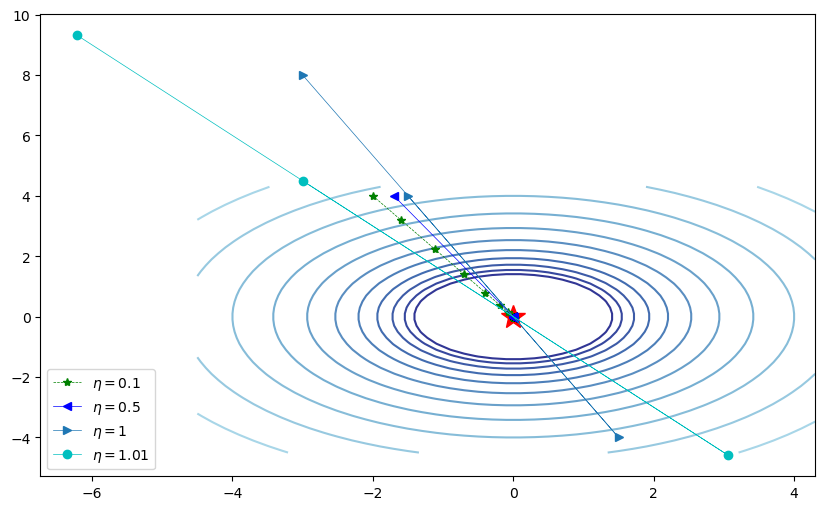

In [6]:
plt.close()
a,b = 1.0,1.0
gamma = 0.5
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(minima_surface(x,y,a,b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18) 

init3_mod=[-0.1,0.1]

gd_nag_1=NAG(grad_minima_surface,init1, n_epochs=100, eta=eta1, a=a, b=b, gamma = gamma)
gd_nag_2=NAG(grad_minima_surface,init2, n_epochs=100, eta=eta2, a=a, b=b, gamma = gamma)
gd_nag_3=NAG(grad_minima_surface,init3, n_epochs=2, eta=eta3, a=a, b=b, gamma = gamma)
gd_nag_4=NAG(grad_minima_surface,init4, n_epochs=2, eta=eta4, a=a, b=b, gamma = gamma)
print(gd_nag_1, gd_nag_2, gd_nag_3, gd_nag_4)
overlay_trajectory_contour(ax,gd_nag_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_nag_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_nag_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_nag_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=3)
plt.show()

Using the nag algorithm the system converges faster wrt other algorithms fo $\eta = 0.1$, gaining 5 orders of magnitude in the same 100 epochs. It also reduces the amplitude of the oscillations around the minimum.

For $\eta = 0.5$ we retrieve the one shot convergence we had with gd.

For values of $\eta > 0.5$ the system rapidly oveshoots beyond the minimum. This is due to the fact that with NAG we evaluate the gradient at the next point, so that the update becomes more anticipatory, and so if $\eta$ gets too large we can land farther from the minimum, causing larger updates which makes overshooting more severe.

## The effect of anisotropy

[[-2.00000000e+00  2.00000000e+00]
 [-8.00000000e-01  1.60000000e+00]
 [-3.20000000e-01  1.28000000e+00]
 [-1.28000000e-01  1.02400000e+00]
 [-5.12000000e-02  8.19200000e-01]
 [-2.04800000e-02  6.55360000e-01]
 [-8.19200000e-03  5.24288000e-01]
 [-3.27680000e-03  4.19430400e-01]
 [-1.31072000e-03  3.35544320e-01]
 [-5.24288000e-04  2.68435456e-01]
 [-2.09715200e-04  2.14748365e-01]
 [-8.38860800e-05  1.71798692e-01]
 [-3.35544320e-05  1.37438953e-01]
 [-1.34217728e-05  1.09951163e-01]
 [-5.36870912e-06  8.79609302e-02]
 [-2.14748365e-06  7.03687442e-02]
 [-8.58993459e-07  5.62949953e-02]
 [-3.43597384e-07  4.50359963e-02]
 [-1.37438953e-07  3.60287970e-02]
 [-5.49755814e-08  2.88230376e-02]
 [-2.19902326e-08  2.30584301e-02]
 [-8.79609302e-09  1.84467441e-02]
 [-3.51843721e-09  1.47573953e-02]
 [-1.40737488e-09  1.18059162e-02]
 [-5.62949953e-10  9.44473297e-03]
 [-2.25179981e-10  7.55578637e-03]
 [-9.00719925e-11  6.04462910e-03]
 [-3.60287970e-11  4.83570328e-03]
 [-1.44115188e-11  3

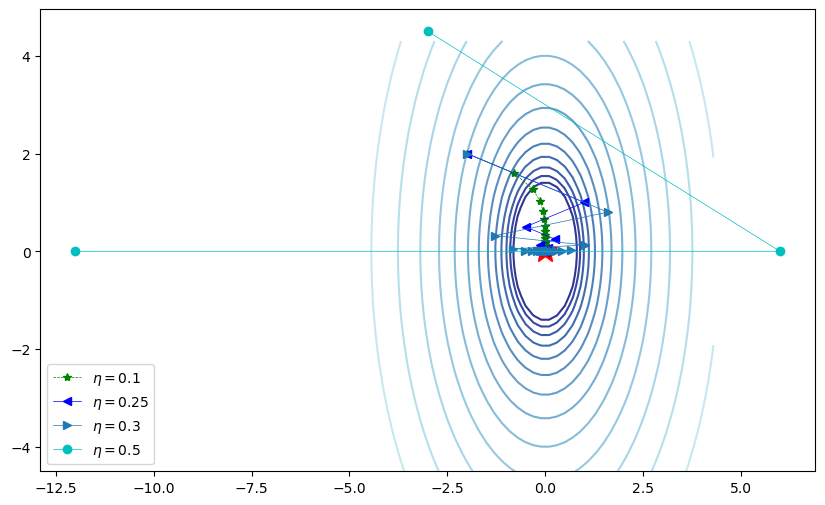

In [7]:
# Investigate effect of learning rate in GD
plt.close()
a,b = 3.0,1.0
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(minima_surface(x,y,a,b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,2]
init2=[-1.7,4]
init3=[-1.5,4]
init4=[-3,4.5]
eta1=0.1
eta2=0.25
eta3=0.3
eta4=0.5
gd_1=gd(grad_minima_surface,init1, n_epochs=100, eta=eta1, a=a, b=b)
gd_2=gd(grad_minima_surface,init1, n_epochs=100, eta=eta2, a=a, b=b)
gd_3=gd(grad_minima_surface,init1, n_epochs=100, eta=eta3, a=a, b=b)
gd_4=gd(grad_minima_surface,init4, n_epochs=2, eta=eta4, a=a, b=b)
print(gd_1, gd_2, gd_3, gd_4)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=3)
plt.show()
#fig.savefig("GD3regimes.pdf", bbox_inches='tight')


If we have an anistropic surface with a small learning rate $\eta = 0.1$ the system is able to converge to the minimum, with a faster pace along the steeper direction, more slowly along the other. For slightly larger values of eta ($\eta = 0.3$) the trend is inversed. Thus testing for an intermediate value ($\eta = 0.25$), I noted a more even descent: after 100 epochs both x and y variables reach values on the order of $10^{-30}$. We can note a zig-zagging behaviour due to the different gradients in the two directions.

For larger values of the learning rate the system first start to oscillate around the minimum (for $\eta = 0.5$) and then to overshoot from it (for $\eta = 1$ and $\eta = 1.01$).

[[-2.00000000e+00  2.00000000e+00]
 [-8.00000000e-01  1.60000000e+00]
 [ 2.80000000e-01  1.08000000e+00]
 [ 6.52000000e-01  6.04000000e-01]
 [ 4.46800000e-01  2.45200000e-01]
 [ 7.61200000e-02  1.67600000e-02]
 [-1.54892000e-01 -1.00812000e-01]
 [-1.77462800e-01 -1.39435600e-01]
 [-8.22705200e-02 -1.30860280e-01]
 [ 1.46879320e-02 -1.00400564e-01]
 [ 5.43543988e-02 -6.50905932e-02]
 [ 4.15749929e-02 -3.44174892e-02]
 [ 1.02402942e-02 -1.21974393e-02]
 [-1.15712317e-02  1.35207348e-03]
 [-1.55342556e-02  7.85641518e-03]
 [-8.19521422e-03  9.53730299e-03]
 [ 3.91435008e-04  8.47028630e-03]
 [ 4.44989861e-03  6.24272069e-03]
 [ 3.80919125e-03  3.88039375e-03]
 [ 1.20332282e-03  1.92315153e-03]
 [-8.21605089e-04  5.59900114e-04]
 [-1.34110599e-03 -2.33705617e-04]
 [-7.96192845e-04 -5.83767359e-04]
 [-4.60205664e-05 -6.42044759e-04]
 [ 3.56677913e-04 -5.42774506e-04]
 [ 3.44020405e-04 -3.84584479e-04]
 [ 1.31279408e-04 -2.28572570e-04]
 [-5.38587353e-05 -1.04852101e-04]
 [-1.14112566e-04 -2

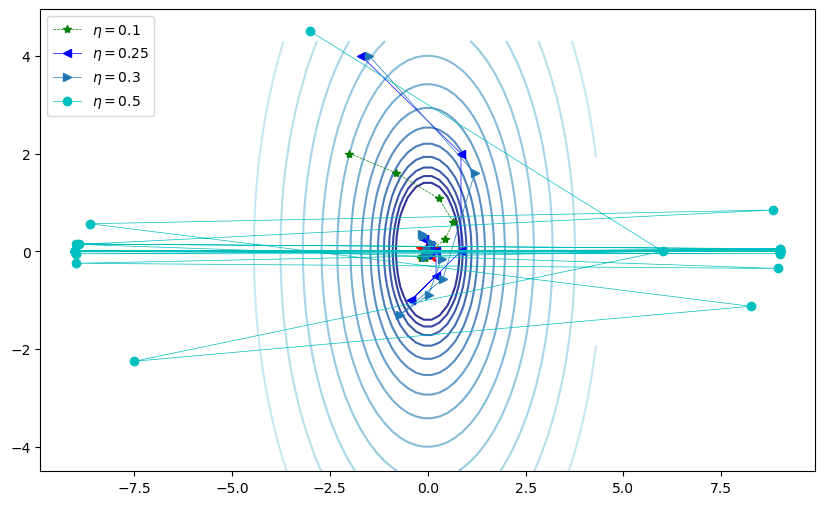

In [8]:
plt.close()
a,b = 3.0,1.0
gamma = 0.5
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(minima_surface(x,y,a,b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18) 

#initial point
init1=[-2,2]
init2=[-1.7,4]
init3=[-1.5,4]
init4=[-3,4.5]
eta1=0.1
eta2=0.25
eta3=0.3
eta4=0.5

gd_mom_1=gd_with_mom(grad_minima_surface,init1, n_epochs=100, eta=eta1, a=a, b=b, gamma = gamma)
gd_mom_2=gd_with_mom(grad_minima_surface,init2, n_epochs=100, eta=eta2, a=a, b=b, gamma = gamma)
gd_mom_3=gd_with_mom(grad_minima_surface,init3, n_epochs=100, eta=eta3, a=a, b=b, gamma = gamma)
gd_mom_4=gd_with_mom(grad_minima_surface,init4, n_epochs=50, eta=eta4, a=a, b=b, gamma = gamma)
print(gd_mom_1, gd_mom_2, gd_mom_3, gd_mom_4)
overlay_trajectory_contour(ax,gd_mom_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_mom_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_mom_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_mom_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.show()

Up to values of $\eta \sim 0.3$ the optimization algorithm approaches the minimum evenly, reaching $10^{-15}$ for both x and y.
As we approach $0.5$ the minimization process starts to become more uneven, up  to the point for $\eta = 0.5$ in which the iterations oscillates back and forth around $y = 0$.

For larger values the system overshoots.

[[-2.00000000e+00  2.00000000e+00]
 [-8.00000000e-01  1.60000000e+00]
 [-8.00000000e-02  1.12000000e+00]
 [ 1.12000000e-01  7.04000000e-01]
 [ 8.32000000e-02  3.96800000e-01]
 [ 2.75200000e-02  1.94560000e-01]
 [-1.28000000e-04  7.47520000e-02]
 [-5.58080000e-03  1.18784000e-02]
 [-3.32288000e-03 -1.56467200e-02]
 [-8.77568000e-04 -2.35274240e-02]
 [ 1.38035200e-04 -2.19742208e-02]
 [ 2.58334720e-04 -1.69580954e-02]
 [ 1.27393792e-04 -1.15600261e-02]
 [ 2.47693312e-05 -7.08879319e-03]
 [-1.06171597e-05 -3.88254138e-03]
 [-1.13241620e-05 -1.82353238e-03]
 [-4.67106529e-06 -6.35222308e-04]
 [-5.37806766e-07 -3.28538155e-05]
 [ 6.11528999e-07  2.14664345e-04]
 [ 4.74478753e-07  2.70738740e-04]
 [ 1.62381452e-07  2.39020750e-04]
 [ 2.53312054e-09  1.78529404e-04]
 [-3.09564180e-08  1.18626985e-04]
 [-1.90804749e-08  7.09406201e-05]
 [-5.25700135e-09  3.76779502e-05]
 [ 6.61894175e-10  1.68372923e-05]
 [ 1.44853678e-09  5.13357061e-06]
 [ 7.36743230e-10 -5.74632172e-07]
 [ 1.52338583e-10 -2

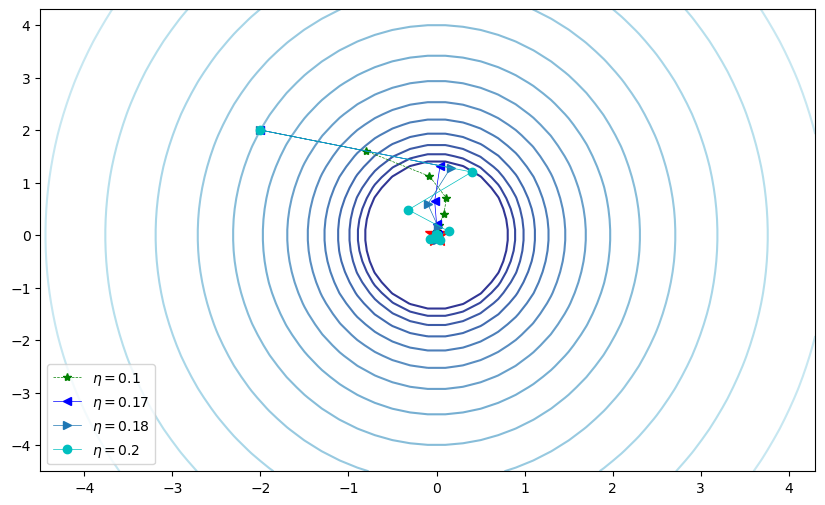

In [9]:
plt.close()
a,b = 3.0,1.0
gamma = 0.5
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(minima_surface(x,y,a,b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18) 

#initial point
init1=[-2,2]
init2=[-1.7,4]
init3=[-1.5,4]
init4=[-3,4.5]
eta1=0.1
eta2=0.17
eta3=0.18
eta4=0.2

gd_nag_1=NAG(grad_minima_surface,init1, n_epochs=100, eta=eta1, a=a, b=b, gamma = gamma)
gd_nag_2=NAG(grad_minima_surface,init1, n_epochs=100, eta=eta2, a=a, b=b, gamma = gamma)
gd_nag_3=NAG(grad_minima_surface,init1, n_epochs=100, eta=eta3, a=a, b=b, gamma = gamma)
gd_nag_4=NAG(grad_minima_surface,init1, n_epochs=100, eta=eta4, a=a, b=b, gamma = gamma)
print(gd_nag_1, gd_nag_2, gd_nag_3, gd_nag_4)
overlay_trajectory_contour(ax,gd_nag_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_nag_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_nag_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_nag_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=3)
plt.show()

Using the NAG algorithm we note that the convergence is much faster: for $\eta = 0.1$, after 100 epochs the iterations reach $10^{-38}$ for x and $10^{-20}$ for y, this can be even sped up using a learning rate close to $0.17$.

It is also much more dependent on the value of the learning rate, for $\eta > 0.2$ the system overshoots.


## Gradient Descents that utilize the second moment

In stochastic gradient descent, with and without momentum, we still have to specify a  schedule for tuning the learning rates $\eta_t$ as a function of time. As discussed in Sec. IV in the context of Newton's method, this presents a number of dilemmas. The learning rate is limited by the steepest direction which can change depending on where in the landscape we are. To circumvent this problem, ideally our algorithm would take large steps in shallow, flat directions and small steps in steep, narrow directions. Second-order methods accomplish this by calculating or approximating the Hessian and normalizing the learning rate by the curvature. However, this is very computationally expensive for extremely large models.  Ideally, we would like to be able to adaptively change our step size to match the landscape without paying the steep computational price of calculating or approximating Hessians.

Recently, a number of methods have been introduced that accomplish this by tracking not only the gradient but also the second moment of the gradient. These methods include AdaGrad, AdaDelta, RMS-Prop, and ADAM. Here, we discuss the latter of these two as representatives of this class of algorithms.


In RMS prop (Root-Mean-Square propagation), in addition to keeping a running average of the first moment of the gradient, we also keep track of the second moment through a moving average. The update rule for RMS prop is given by
$$
\mathbf{g}_t = \nabla_\theta E(\boldsymbol{\theta}) \\
\mathbf{s}_t =\beta \mathbf{s}_{t-1} +(1-\beta)\mathbf{g}_t^2 \nonumber \\
\boldsymbol{\theta}_{t+1}=\boldsymbol{\theta}_t + \eta_t { \mathbf{g}_t \over \sqrt{\mathbf{s}_t +\epsilon}}, \nonumber \\
$$
where $\beta$ controls the averaging time of the second moment and is typically taken to be about $\beta=0.9$, $\eta_t$ is a learning rate typically chosen to be $10^{-3}$, and $\epsilon\sim 10^{-8}$ is a small regularization constant to prevent divergences. It is clear from this formula that the learning rate is reduced in directions where the norm of the gradient is consistently large. This greatly speeds up the convergence by allowing us to use a larger learning rate for flat directions.

A related algorithm is the ADAM optimizer. In ADAM, we keep a running average of both the first and second moment of the gradient and use this information to adaptively change the learning rate for different parameters. In addition to keeping a running average of the first and second moments of the gradient, ADAM performs an additional bias correction to account for the fact that we are estimating the first two moments of the gradient using a running average (denoted by the hats in the update rule below). The update rule for ADAM is given by (where multiplication and division are understood to be element wise operations)
$$
\mathbf{g}_t = \nabla_\theta E(\boldsymbol{\theta}) \\
\mathbf{m}_t = \beta_1 \mathbf{m}_{t-1} + (1-\beta_1) \mathbf{g}_t \nonumber \\
\mathbf{s}_t =\beta_2 \mathbf{s}_{t-1} +(1-\beta_2)\mathbf{g}_t^2 \nonumber \\
\hat{\mathbf{m}}_t={\mathbf{m}_t \over 1-\beta_1} \nonumber \\
\hat{\mathbf{s}}_t ={\mathbf{s}_t \over1-\beta_2} \nonumber \\
\boldsymbol{\theta}_{t+1}=\boldsymbol{\theta}_t + \eta_t { \hat{\mathbf{m}}_t \over \sqrt{\hat{\mathbf{s}}_t +\epsilon}}, \nonumber 
$$
where $\beta_1$ and $\beta_2$ set the memory lifetime of the first and second moment and are typically take to be $0.9$ and $0.99$ respectively, and $\eta$ and $\epsilon$ are identical
to RMSprop.




In [10]:
################################################################################
# Methods that exploit first and second moments of gradient: RMS-PROP and ADAMS
################################################################################

def rms_prop(grad, init, n_epochs=5000, eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init#Import relevant packages
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v=eta*np.divide(g,np.sqrt(grad_sq+epsilon))
        params= params-v
        param_traj[j+1,]=params
    return param_traj
                        
                        
def adams(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

# Experiments with ADAM and RMSprop

In this section, we will experiment with ADAM and RMSprop. To do so, we will use a function commonly used in optimization protocols:

$$
f(x,y)=(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2.
$$

This function has a global minimum at $(x,y)=(3,0.5)$. We will use GD, GD with classical momentum, NAG, RMSprop, and ADAM to find minima starting at different initial conditions.

One of the things you should experiment with is the learning rate and the number of steps, $N_{\mathrm{steps}}$ we take. Initially, we have set $N_{\mathrm{steps}}=10^4$ and the learning rate for ADAM/RMSprop to $\eta=10^{-3}$ and the learning rate for the remaining methods to $10^{-6}$.
<ul>
<li> Examine the plot for these default values. What do you see?
<li> Make a plot when the learning rate of all methods is $\eta=10^{-6}$? How does your plot change?
<li> Now set the learning rate for all algorithms to $\eta=10^{-3}$? What goes wrong? Why?
</ul>

In [11]:
plt.close()
#Make static plot of the results
Nsteps=10**4
#Learning rate for the ADAM/RMSprop
lr_l=10**-3
#Learning rate for the GD/GD with momentum/NAG methods
lr_s=10**-6

[3.71072266 0.72708101] [3.60015606 0.61725268] [3.62328691 0.62071819] [3.00047134 0.49949234] [3.  0.5]


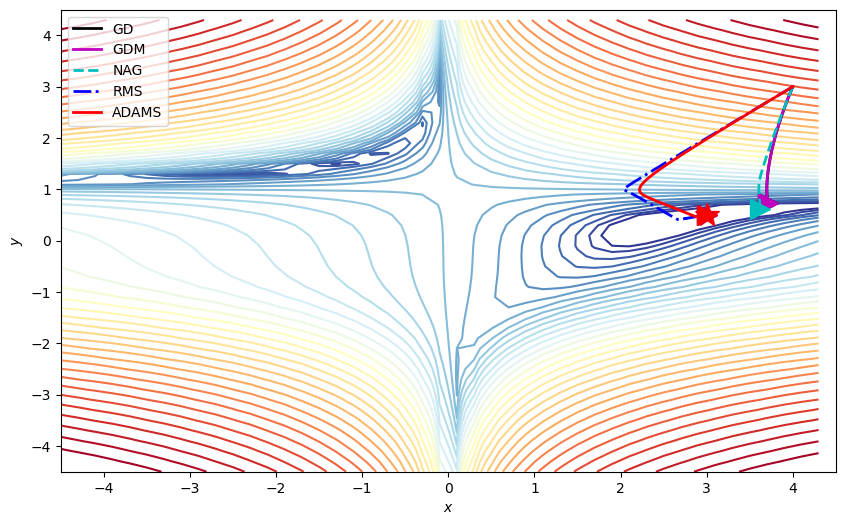

In [12]:
init1=np.array([4,3])
fig1, ax1=contour_beales_function()

gd_trajectory1=gd(grad_beales_function,init1,Nsteps, eta=lr_s, noise_strength=0)
gdm_trajectory1=gd_with_mom(grad_beales_function,init1,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory1=NAG(grad_beales_function,init1,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory1=rms_prop(grad_beales_function,init1,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory1=adams(grad_beales_function,init1,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

print(gd_trajectory1[-1][:], gdm_trajectory1[-1][:], NAG_trajectory1[-1][:], rms_prop_trajectory1[-1][:], adam_trajectory1[-1][:])

overlay_trajectory_contour_M(ax1,gd_trajectory1, 'GD','k')
overlay_trajectory_contour_M(ax1,gd_trajectory1, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory1, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory1,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory1,'ADAMS', 'r')

plt.legend(loc=2)
plt.show()

In the standard configuration ($\eta = 10^{-3}$ for the ADAM/RMS prop methods and $\eta = 10^{-6}$ for all the others), for these initial conditions $(4,3)$, first quadrant, ADAM reaches the minimum exactly, RMS prop obtains it with a precision in the third decimal digit, while the other methods get trapped in local minima.

[1.43520072 0.88732773] [1.78537109 0.22911104] [1.78549047 0.22920993] [3.00047134 0.49949234] [3.00000715 0.49999283]


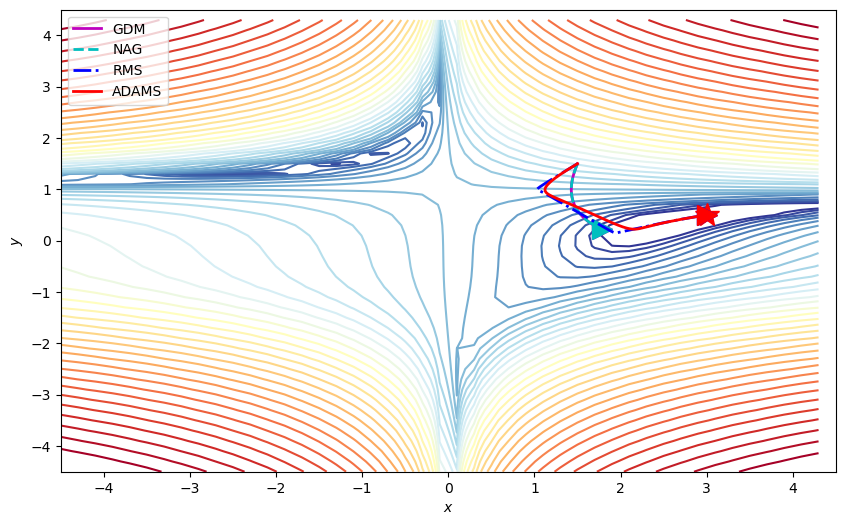

In [13]:
init2=np.array([1.5,1.5])
fig1, ax1=contour_beales_function()

gd_trajectory2=gd(grad_beales_function,init2,Nsteps, eta=10**-6, noise_strength=0)
gdm_trajectory2=gd_with_mom(grad_beales_function,init2,Nsteps,eta=10**-6, gamma=0.9,noise_strength=0)
NAG_trajectory2=NAG(grad_beales_function,init2,Nsteps,eta=10**-6, gamma=0.9,noise_strength=0)
rms_prop_trajectory2=rms_prop(grad_beales_function,init2,Nsteps,eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory2=adams(grad_beales_function,init2,Nsteps,eta=10**-3, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

print(gd_trajectory2[-1][:], gdm_trajectory2[-1][:], NAG_trajectory2[-1][:], rms_prop_trajectory2[-1][:], adam_trajectory2[-1][:])

overlay_trajectory_contour_M(ax1,gdm_trajectory2, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory2, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory2,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory2,'ADAMS', 'r')

plt.legend(loc=2)
plt.show()

[-0.07211755  3.52370065] [-0.25666545  2.36490455] [-0.08395574  3.3576745 ] [-7.8467444   1.11353141] [-7.20316371  1.12315639]


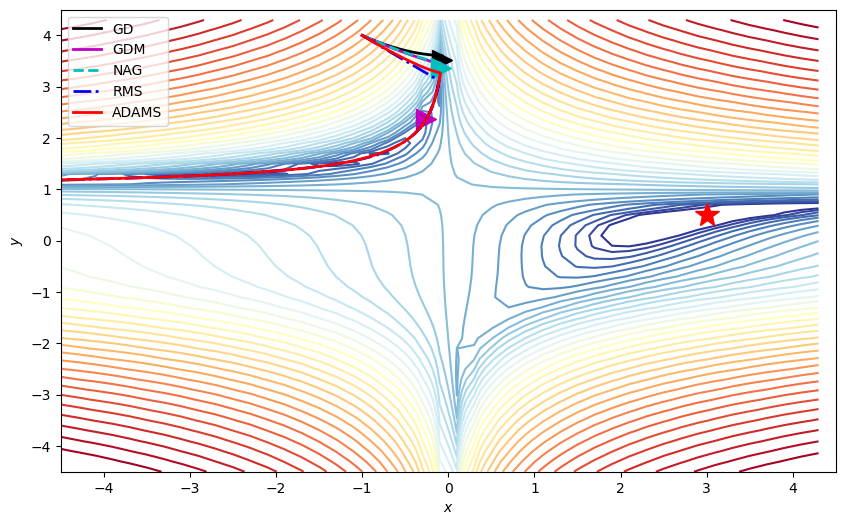

In [14]:
init3=np.array([-1,4])
fig1, ax1=contour_beales_function()

gd_trajectory3=gd(grad_beales_function,init3,10**5, eta=lr_s, noise_strength=0)
gdm_trajectory3=gd_with_mom(grad_beales_function,init3,10**5,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory3=NAG(grad_beales_function,init3,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory3=rms_prop(grad_beales_function,init3,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory3=adams(grad_beales_function,init3,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

print(gd_trajectory3[-1][:], gdm_trajectory3[-1][:], NAG_trajectory3[-1][:], rms_prop_trajectory3[-1][:], adam_trajectory3[-1][:])

overlay_trajectory_contour_M(ax1,gd_trajectory3, 'GD','k')
overlay_trajectory_contour_M(ax1,gdm_trajectory3, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory3, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory3,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory3,'ADAMS', 'r')

plt.legend(loc=2)
plt.show()

With these initial conditions, $(-1,4)$, second quadrant, all methods fail: ADAM and RMS prop are drawn away from the minimum and the others get trapped in local minima

[ 0.12800328 -2.19270857] [ 0.28826683 -1.78379491] [ 0.26370941 -1.8476045 ] [3.00047134 0.49949234] [3.0000352  0.49996417]


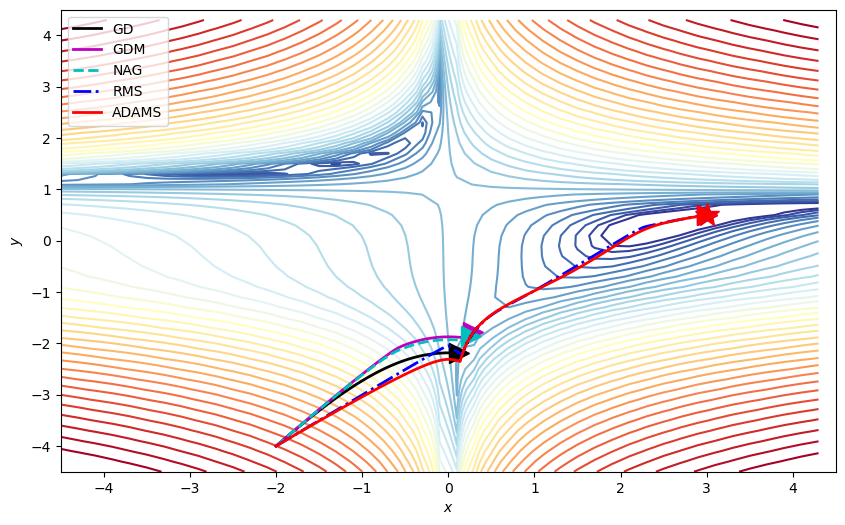

In [15]:
init4=np.array([-2,-4])
fig1, ax1=contour_beales_function()

gd_trajectory4=gd(grad_beales_function,init4,Nsteps, eta=lr_s, noise_strength=0)
gdm_trajectory4=gd_with_mom(grad_beales_function,init4,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory4=NAG(grad_beales_function,init4,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory4=rms_prop(grad_beales_function,init4,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory4=adams(grad_beales_function,init4,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

print(gd_trajectory4[-1][:], gdm_trajectory4[-1][:], NAG_trajectory4[-1][:], rms_prop_trajectory4[-1][:], adam_trajectory4[-1][:])


overlay_trajectory_contour_M(ax1,gd_trajectory4, 'GD','k')
overlay_trajectory_contour_M(ax1,gdm_trajectory4, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory4, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory4,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory4,'ADAMS', 'r')

plt.legend(loc=2)
plt.show()

With these initial conditions $(-2,-4)$, third quadrant, ADAM and RMS prop are able to overcome local minima and reach the absolute minimum of the function (with comparable precision) while the other methods get trapped.

[ 0.18475493 -2.19645168] [ 0.29007783 -1.77933796] [ 0.26481369 -1.84458977] [2.99947143 0.50049233] [2.99997229 0.50002777]


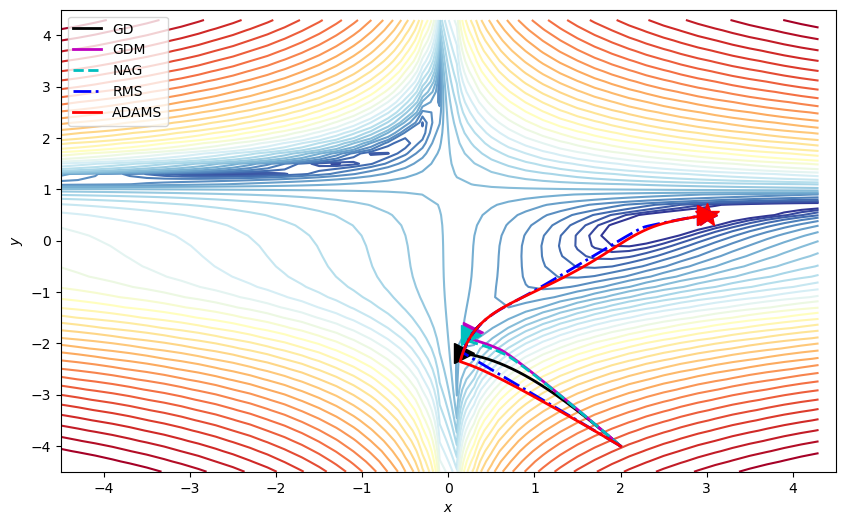

In [16]:
init5=np.array([2,-4])
fig1, ax1=contour_beales_function()

gd_trajectory5=gd(grad_beales_function,init5,Nsteps, eta=lr_s, noise_strength=0)
gdm_trajectory5=gd_with_mom(grad_beales_function,init5,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory5=NAG(grad_beales_function,init5,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory5=rms_prop(grad_beales_function,init5,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory5=adams(grad_beales_function,init5,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

print(gd_trajectory5[-1][:], gdm_trajectory5[-1][:], NAG_trajectory5[-1][:], rms_prop_trajectory5[-1][:], adam_trajectory5[-1][:])


overlay_trajectory_contour_M(ax1,gd_trajectory5, 'GD','k')
overlay_trajectory_contour_M(ax1,gdm_trajectory5, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory5, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory5,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory5,'ADAMS', 'r')

plt.legend(loc=2)
plt.show()

In the standard configuration ($\eta = 10^{-3}$ for the ADAM/RMS prop methods and $\eta = 10^{-6}$ for all the others), the ADAM and RMS prop methods perform better than the others that tend to get stuck in local minima, except in the case of intial conditions on the second quadrant, in which all methods ill perform.

Using a learning rate of $\eta = 10^{-6}$ for all the methods, the ADAM and RMS prop method get basically stuck at the initial point while the other methods are basically left unchanged. In all these cases we are starting in points
which are far from the minimum and in which the learning rate is so small that it kills all the action of the gradient (either large or even worse in flat regions), leading to the system reaching a full stop.

This is due to the fact that for ADAM and RMS prop the evolution of the parameters depend on both the gradient and the square root of the variance, i.e. the avrerage of the gradient squared, 
$$
\boldsymbol{\theta}_{t+1}=\boldsymbol{\theta}_t + \eta_t { \hat{\mathbf{m}}_t \over \sqrt{\hat{\mathbf{s}}_t +\epsilon}}, \nonumber
$$
so with tiny learning rates you may end up with updates on the order of $10^{-9}$, which make the optimizer stuck. The other methods do not scale their step sizes based on past gradient variance and are less sensitive to LR.

Insted for case 2 with $(1.5, 1.5)$ as intial point, the gradients are not too small but not too extreme either so the variance is more stable and so the optimizer can work.

Using a learning rate of $\eta = 10^{-3}$ for all the methods, the ADAM and RMS prop method work well while the others are strongly oscillating. Again this is due to the adaptive nature of the sidesteps and the rugged outlook of Beale's function.

In regions far from the minimum gradients can be large and a too large fixed stepsize in the GD method can lead to huge updates, this gets even worse for momentum and NAG: if gradients are large, the velocity builds up quickly and so the updates can become even larger. With ADAM and RMS prop insted the adaptive denominator normalizes the raw gradient: scaling down large gradients and avoiding exploding steps, thus adapting to the high curvature directions, sharp valleys and changes in gradient scale present in Beale's function. It is like riding a bumpy mountain with smart brakes that adapt to the steepness rather than going too fast with no brakes: you fly off the tracks.

Again for case 2 with $(1.5, 1.5)$ as intial point, the landscape is less steep and less curved and so the optimizer can work.